Here, we plot the time-varying reversal rates in the pre-activation and the post activation periods.
We can also plot the reversal events/rates as a function of distance travelled.

In [67]:
import numpy as np
import scipy.stats
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import Layout,Button,Box,VBox,Label
import plotly as ply

from dance_sim_tools.ipywidget_helpers import slider,intslider
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [106]:
from operator import sub
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

In [68]:
def rads_to_bls(theta):
    return np.degrees(theta)*(np.pi/9)/2.4
def degs_to_bls(theta):
    return theta*(np.pi/9)/2.4
trials_per_cond = [23,21,26]
cond_strs = ['1LED','2LED60','2LED90']
max_reversal_count = 50
after_fly_inds = [[1,2,3,4,6,7,9,11,12,14,15,17,18,19,20,21,22,23],
    list(range(1,22)),
    [1,2,3,4,6,8,10,11,13,15,16,17,18,19,20,22,23,24,25,26]]
max_fly_count = max(max(after_fly_inds))

In [69]:
def reversal_raster_by_time(condition):
 
    #Start a matrix that will host reversal times for all flies for the condition
    bef_rev_times_cond = np.full((max_fly_count,max_reversal_count),0.)
    af_rev_times_cond = np.full((max_fly_count,max_reversal_count),0.)
    
    
    #Collect the reversal times for each fly into this matrix
    num_flies = trials_per_cond[condition-1]
    
    before_flies = list(range(num_flies))
    after_flies = after_fly_inds[condition-1]
    
    for fly in before_flies:
        bef_revs_filename = 'rev_data_be/'+'RE_t_be_'+str(condition)+'_'+str(fly+1)+'.txt'
        bef_revs = np.loadtxt(bef_revs_filename)
        bef_rev_times_cond[fly,:len(bef_revs)] =bef_revs
    for fly in after_flies:
        af_revs_filename = 'rev_data_af/'+'RE_t_af1_'+str(condition)+'_'+str(fly)+'.txt'
        af_revs = np.loadtxt(af_revs_filename)
        af_rev_times_cond[fly-1,:len(af_revs)] = af_revs
        
    
    cond_fly_count = max(max(before_flies),max(after_flies))
    
    before_flies_bool = np.zeros(cond_fly_count).astype(bool)
    after_flies_bool = np.zeros(cond_fly_count).astype(bool)
    before_flies_bool[before_flies] = True
    after_flies_bool[np.array(after_flies)-1] = True
    
    intersecting_flies_inds = np.arange(1,max_fly_count+1)
    
    plt.figure(figsize=(12,4))
    
    ax = plt.subplot(121)
    plt.title('Pre-Activation Reversals')
    plt.xlim([0,10])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)        
    
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_bef = np.where(np.logical_not(before_flies_bool))[0]
    bef_rev_times_cond[empty_flies_bef,1] = 1
    linelengths[empty_flies_bef] = np.exp(-10)
    ax.eventplot(bef_rev_times_cond, color=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Time (min)')
    
    
    
    ax = plt.subplot(122)
    plt.title('Post-Activation Reversals')
    plt.xlim([50,60])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)          
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_af = np.where(np.logical_not(after_flies_bool))[0]
    af_rev_times_cond[empty_flies_af,1] = 1
    linelengths[empty_flies_af] = np.exp(-10)

    
    ax.eventplot(af_rev_times_cond, colors=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Time (min)')
    
    plt.show()
    
    
    
#start,stop,step,init
# sm=intslider('m',3,10,1,5)
#sfly_sample = intslider('which_fly',0,22,1,0)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
sliders = [condition_toggle]#,sfly_sample,m]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='row',
    border='solid 2px',
    align_items='stretch',
    width='60%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(reversal_raster_by_time, param_dict)



display(ui,out)



Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 1), ('2F 60', 2), ('2F 90', …

Output()

Now, we are interested in making a convolution of each of these event signals with a square wave (time window).

First we need to convert the fly reversal-time lists to steady time signals.


In [235]:
bef_duration = 10
af_duration = 2

def reversal_lambda_by_time(condition,dt,display=False):
 
    bef_time_steps = int(np.ceil(bef_duration*60/dt))
    bef_time_vals = np.linspace(0.,bef_duration,bef_time_steps)[None,:]  #(dims are (reversal_times x timesteps))
    
    af_start_time = 50
    af_time_steps = int(np.ceil(af_duration*60/dt))
    af_time_vals = np.linspace(af_start_time,af_start_time+af_duration,af_time_steps)[None,:]  #(dims are (reversal_times x timesteps))
    
    #Start a matrix that will host a *steady time boolean reversal signal* for all flies for the condition
    bef_rev_times_bool = np.full((max_fly_count,bef_time_steps),0).astype(bool)
    
    af_rev_times_bool = np.full((max_fly_count,af_time_steps),0).astype(bool)
    
    #Collect the reversal times for each fly into this matrix
    num_flies = trials_per_cond[condition-1]
    
    before_flies = list(range(num_flies))
    after_flies = after_fly_inds[condition-1]
    
    
    for fly in before_flies:
        bef_revs_filename = 'rev_data_be/'+'RE_t_be_'+str(condition)+'_'+str(fly+1)+'.txt'
        bef_revs = np.loadtxt(bef_revs_filename)[:,None] #(dims are (reversal_times x timesteps))       
        bef_revs_inds = np.argmin(np.abs(bef_time_vals-bef_revs),axis=1)       
        bef_rev_times_bool[fly,bef_revs_inds] = True
        
    if display:
        plt.figure()
        plt.imshow(bef_rev_times_bool,aspect=(n_time_steps/num_flies),interpolation='bilinear')
        plt.show()
    
    
    for fly in after_flies:
        af_revs_filename = 'rev_data_af/'+'RE_t_af1_'+str(condition)+'_'+str(fly)+'.txt'
        af_revs = np.loadtxt(af_revs_filename)[:,None] #(dims are (reversal_times x timesteps))
        af_revs_inds = np.argmin(np.abs(af_time_vals-af_revs),axis=1)
        af_rev_times_bool[fly-1,af_revs_inds] = True 
        
    
    return bef_rev_times_bool,af_rev_times_bool,bef_time_vals,af_time_vals
  

#Example call
bef_rev_times_bool,af_rev_times_bool,bef_time_vals,af_time_vals = reversal_lambda_by_time(condition=3,dt=0.25)
#These arrays are actually kind of hard to look at using embedded matplotlib blurring tools, i think
#so just go ahead and start blurring/averaging

def square_wave_convolve_rows(a,window_width,filter_type=2):
    #Accepts a 2d array, and convolves the array in the direction of the second axis (horizontally)
    #with a square wave window (moving average) of integer width window_width
    a = a.astype(float)
    num_flies,n_timesteps = np.shape(a) 
    filt = np.zeros(n_timesteps)
    if filter_type==1:
        #option 1: square filter
        filt[:window_width] =1.
    if filter_type==2:
        #option 2: triangle filter
        half_val = int(np.floor(window_width/2)) 
        filt[:half_val] = np.arange(1,half_val+1,1)
        filt[half_val:window_width] = np.arange(half_val+1,1,-1)
    
    return ndimage.convolve1d(a,filt[:window_width],axis=1,mode='constant',cval=0.)

def plot_window_avgd_reversals(condition,window_width_sec=30,prct_val=95,dt=0.25,filter_type=2):

    window_width_inds = int(np.ceil(window_width_sec/dt))
    
    bef_rev_times_bool,af_rev_times_bool,bef_time_vals,af_time_vals = reversal_lambda_by_time(condition,dt)

    bef_rev_times_im,af_rev_times_im = \
        square_wave_convolve_rows(bef_rev_times_bool,window_width_inds,filter_type=filter_type), \
            square_wave_convolve_rows(af_rev_times_bool,window_width_inds,filter_type=filter_type)  

    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(221)
    plt.title('Pre-Activation Reversals')
    im_pre = plt.imshow(bef_rev_times_im,
                        extent=(0,10,max_fly_count,0),
                        aspect='auto',vmin=np.min(af_rev_times_im),vmax=np.max(af_rev_times_im))
    plt.xlabel('Time (min)')
    plt.ylabel('Fly')
    asp = get_aspect(ax1)
    
    
    ax2 = plt.subplot(222)
    plt.title('Post-Activation Reversals')
    plt.xlabel('Time (min)')
    plt.ylabel('Fly')

    im_post = plt.imshow(af_rev_times_im,
                         extent=(0,2,max_fly_count,0),
                         aspect=-1*asp,
                         vmin=np.min(af_rev_times_im),vmax=np.max(af_rev_times_im))
    
    #For the next two plots, it matters that we set
    
    nan_bef_rows = (np.sum(bef_rev_times_im,axis=1)<1.)
    bef_rev_times_im[nan_bef_rows] = np.nan

    nan_af_rows = (np.sum(af_rev_times_im,axis=1)<1.)
    af_rev_times_im[nan_af_rows] = np.nan
    
    ax3 = plt.subplot(223)
    plt.title('Pre-Activation Reversals')
    plt.xlabel('Time (min)')

    #old version: plot all values on top of each other
#    bef_time_vals0 = np.repeat(bef_time_vals,max_fly_count,axis=0)
 #   fly_rows = np.repeat(np.arange(0,max_fly_count,1)[:,None],len(bef_time_vals[0]),axis=1)
  
#     plt.scatter(bef_time_vals0,bef_rev_times_im,c=fly_rows,cmap='gist_earth',s=0.1)

    #mean and stdv
    means_of_rates = np.nanmean(bef_rev_times_im,axis=0)
    index_percentiles = np.nanpercentile(bef_rev_times_im,[50-prct_val/2,50+prct_val/2],axis=0)


    bef_time_vals = bef_time_vals.flatten()
    
    plt.plot(bef_time_vals,means_of_rates,label='smoothed reversal rate mean')
    ax3.fill_between(bef_time_vals,
                    index_percentiles[0,:],index_percentiles[1,:],
                        color='powderblue',alpha=0.6,label=str(prct_val)+' CI')
    plt.legend()
    
    ax4 = plt.subplot(224)
    #ax4.set_aspect(-1*asp)
    plt.title('Post-Activation Reversals')
    plt.xlabel('Time (min)')

    #mean and stdv
    means_of_rates = np.nanmean(af_rev_times_im,axis=0)
    index_percentiles = np.nanpercentile(af_rev_times_im,[50-prct_val/2,50+prct_val/2],axis=0)


    af_time_vals = af_time_vals.flatten()
    
    plt.plot(af_time_vals,means_of_rates,label='smoothed reversal rate mean',color='crimson')
    ax4.fill_between(af_time_vals,
                    index_percentiles[0,:],index_percentiles[1,:],
                        alpha=0.6,label=str(prct_val)+' CI',color='lightcoral')
    
    ax3.set_ylim([0,ax4.get_ylim()[1]])
    ax4.set_ylim([0,ax4.get_ylim()[1]])
    
    
    plt.legend()
    
    plt.show()
    
#start,stop,step,init
sdt=slider('dt',0.01,0.5,0.01,0.25,readout_format='.2f')
swindow_width_sec= slider('window_width_sec',1,121,10,31)
sprct_val= slider('prct_val',60,99,1,95)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
filter_type_toggle = widgets.RadioButtons(options=[('square',1), ('triangle',2)],
                                          disabled=False,description='filter_type')

sliders = [sdt,swindow_width_sec,sprct_val,condition_toggle,filter_type_toggle]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    width='=100%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))

out = widgets.interactive_output(plot_window_avgd_reversals, param_dict)

display(ui,out)

Box(children=(Box(children=(FloatSlider(value=0.25, continuous_update=False, description='dt', max=0.5, min=0.…

Output()

now, let's do the straight binned version.

In [236]:
def plot_window_avgd_reversals(condition,window_width_sec=30,prct_val=95,dt=0.25,filter_type=2):

    window_width_inds = int(np.ceil(window_width_sec/dt))
    
    bef_rev_times_bool,af_rev_times_bool,bef_time_vals,af_time_vals = reversal_lambda_by_time(condition,dt)
  
    bef_rev_times_im,af_rev_times_im = \
        square_wave_convolve_rows(bef_rev_times_bool,window_width_inds,filter_type=filter_type), \
            square_wave_convolve_rows(af_rev_times_bool,window_width_inds,filter_type=filter_type)  

    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(221)
    plt.title('Pre-Activation Reversals')
    im_pre = plt.imshow(bef_rev_times_im,
                        extent=(0,10,max_fly_count,0),
                        aspect='auto',vmin=np.min(af_rev_times_im),vmax=np.max(af_rev_times_im))
    plt.xlabel('Time (min)')
    plt.ylabel('Fly')
    asp = get_aspect(ax1)
    
    
    ax2 = plt.subplot(222)
    plt.title('Post-Activation Reversals')
    plt.xlabel('Time (min)')
    plt.ylabel('Fly')

    im_post = plt.imshow(af_rev_times_im,
                         extent=(0,2,max_fly_count,0),
                         aspect=-1*asp,
                         vmin=np.min(af_rev_times_im),vmax=np.max(af_rev_times_im))
    
    #For the next two plots, it matters that we set empty fly rows to nan
    
    nan_bef_rows = (np.sum(bef_rev_times_im,axis=1)<1.)
    bef_rev_times_im[nan_bef_rows] = np.nan

    nan_af_rows = (np.sum(af_rev_times_im,axis=1)<1.)
    af_rev_times_im[nan_af_rows] = np.nan
    
 
    #Below: flat rate binning.
   
    #---BEFORE---
    #Select the time bin interval (in minutes) that we'll mean over
    bin_size_min = window_width_sec/60.    
    #Also compute the number of bins this results in
    bef_duration = np.max(bef_time_vals)
    n_bins_bef = np.ceil(bef_duration/bin_size_min).astype(int)
    #+ the number of time steps in each bin
    window_width_inds = int(np.ceil(window_width_sec/dt))       
    bin_start_inds = (np.arange(n_bins_bef+1)*window_width_inds).astype(int)
 
    ax3 = plt.subplot(223)
    plt.title('Pre-Activation Reversals')
    plt.xlabel('Time (min)')
    
    #Generate the bin-averaged vectors we want to plot: create three 1D arrays for prctupper, mean, prctlower
    prctupper = np.zeros(len(bef_rev_times_im[0]))
    prctlower = np.zeros(len(bef_rev_times_im[0]))
    means = np.zeros(len(bef_rev_times_im[0]))
    
    for bin_num in range(n_bins_bef):
        bin_inds = np.arange(bin_start_inds[bin_num],bin_start_inds[bin_num+1],1).astype(int)
        
        #Compute the mean and CIs for all rows within the column range of the bin
        mean = np.nanmean(bef_rev_times_im[:,bin_inds])
        CI_lower,CI_upper = np.nanpercentile(bef_rev_times_im[:,bin_inds],[50-prct_val/2,50+prct_val/2])
        
        #Fill the relevant indices of the 3 vectors
        prctupper[bin_inds] = CI_upper
        prctlower[bin_inds] = CI_lower
        means[bin_inds] = mean

    bef_time_vals = bef_time_vals.flatten()
    
    plt.plot(bef_time_vals,means,label='binned reversal rate mean')
    ax3.fill_between(bef_time_vals,
                    prctlower,prctupper,
                        color='powderblue',alpha=0.6,label=str(prct_val)+' CI')
    
    plt.legend()

    #----
    
    #---AFTER---
    #Select the time bin interval (in minutes) that we'll mean over
    bin_size_min = window_width_sec/60.    
    #Also compute the number of bins this results in
    af_duration = (np.max(af_time_vals)-np.min(af_time_vals))
    n_bins_af = np.ceil(af_duration/bin_size_min).astype(int)
    #+ the number of time steps in each bin
    window_width_inds = int(np.ceil(window_width_sec/dt))       
    bin_start_inds = (np.arange(n_bins_af+1)*window_width_inds).astype(int)
 
    ax4 = plt.subplot(224)
    plt.title('Post-Activation Reversals')
    plt.xlabel('Time (min)')
    
    #Generate the bin-averaged vectors we want to plot: create three 1D arrays for prctupper, mean, prctlower
    prctupper = np.zeros(len(af_rev_times_im[0]))
    prctlower = np.zeros(len(af_rev_times_im[0]))
    means = np.zeros(len(af_rev_times_im[0]))
    
    for bin_num in range(n_bins_af):
        bin_inds = np.arange(bin_start_inds[bin_num],bin_start_inds[bin_num+1],1).astype(int)
        #Compute the mean and CIs for all rows within the column range of the bin
        mean = np.nanmean(af_rev_times_im[:,bin_inds])
        CI_lower,CI_upper = np.nanpercentile(af_rev_times_im[:,bin_inds],[50-prct_val/2,50+prct_val/2])
        
        #Fill the relevant indices of the 3 vectors
        prctupper[bin_inds] = CI_upper
        prctlower[bin_inds] = CI_lower
        means[bin_inds] = mean

    af_time_vals = af_time_vals.flatten()
        
    
    plt.plot(af_time_vals,means,label='binned reversal rate mean',color='red')
    ax4.fill_between(af_time_vals,
                    prctlower,prctupper,
                        color='lightcoral',alpha=0.6,label=str(prct_val)+' CI')
    
    ax3.set_ylim([0,ax4.get_ylim()[1]])
    ax4.set_ylim([0,ax4.get_ylim()[1]])
  

    
    plt.legend()

    
    
    
    plt.show()
    
#start,stop,step,init
sdt=slider('dt',0.01,0.5,0.01,0.25,readout_format='.2f')
swindow_width_sec= slider('window_width_sec',10,120,10,30)
sprct_val= slider('prct_val',60,99,1,95)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
filter_type_toggle = widgets.RadioButtons(options=[('square',1), ('triangle',2)],
                                          disabled=False,description='filter_type')

sliders = [sdt,swindow_width_sec,sprct_val,condition_toggle,filter_type_toggle]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    width='=100%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))

out = widgets.interactive_output(plot_window_avgd_reversals, param_dict)

display(ui,out)

Box(children=(Box(children=(FloatSlider(value=0.25, continuous_update=False, description='dt', max=0.5, min=0.…

Output()

Now, let's make another raster plot, except instead of time on the x-axis, have cumulated distance.


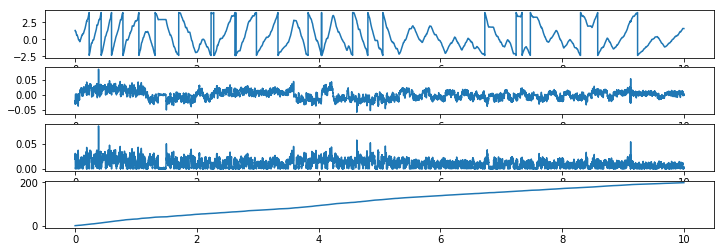

array([ 73.90348536, 126.11806589, 156.41920626])

In [26]:
def cumulated_distance_pre(fly_id,condition,ts,display=False):
    
    #First pull up the theta vector for the relevant fly and condition
    bef_theta_filename = 'rev_data_be/'+'theta_be_'+str(condition)+'_'+str(fly_id)+'.txt'
    bef_theta = np.loadtxt(bef_theta_filename)

    bef_t_filename = 'rev_data_be/'+'t_be_'+str(condition)+'_'+str(fly_id)+'.txt'
    bef_t = np.loadtxt(bef_t_filename)
 #     plt.figure(3)
#     plt.plot(bef_t,np.arange(0,10,dt))
    
    #Compute vector of absolute value of delta thetas
    delta_theta = np.gradient(bef_theta)
    delta_theta[np.abs(delta_theta)>1.] = 0.
    abs_delta_theta = np.abs(delta_theta)
    cum_distance = np.cumsum(abs_delta_theta)
    
    if display:
    
        plt.figure(figsize=(12,4))
        plt.subplot(411)
        plt.plot(bef_t,bef_theta)

        plt.subplot(412)
        plt.plot(bef_t,delta_theta)
        
        plt.subplot(413)
        plt.plot(bef_t,abs_delta_theta)
        
        plt.subplot(414)
        plt.plot(bef_t,cum_distance)
        
        plt.show()
        
    
    t_inds = [np.argmin(np.abs(bef_t - t)) for t in ts]
    
    return cum_distance[t_inds]
    
    
    #Select the index corresponding to the inputted t and sum abs_delta_theta up to that index

#     return cum_distance

#demonstrate how this function computes the cumulated distance 

cumulated_distance_pre(23,1,[3.2,5.3,7.1],display=True)

In [30]:
def reversal_raster_by_time(condition):
 
    #Start a matrix that will host reversal times for all flies for the condition
    bef_rev_dist_cond = np.full((max_fly_count,max_reversal_count),0.)
    af_rev_dist_cond = np.full((max_fly_count,max_reversal_count),0.)
    
    
    #Collect the reversal times for each fly into this matrix
    num_flies = trials_per_cond[condition-1]
    
    before_flies = list(range(num_flies))
    after_flies = after_fly_inds[condition-1]
    
    for fly in before_flies:
        bef_revs_filename = 'rev_data_be/'+'RE_t_be_'+str(condition)+'_'+str(fly+1)+'.txt'
        bef_revs_time = np.loadtxt(bef_revs_filename)
        bef_revs_dist = cumulated_distance_pre(fly+1,condition,bef_revs_time,display=False)
        bef_rev_dist_cond[fly,:len(bef_revs_dist)] =bef_revs_dist
    for fly in after_flies:
        af_revs_filename = 'rev_data_af/'+'RE_t_af1_'+str(condition)+'_'+str(fly)+'.txt'
        af_revs_time = np.loadtxt(af_revs_filename)
        af_revs_dist = cumulated_distance_pre(fly,condition,af_revs_time,display=False)
        af_rev_dist_cond[fly-1,:len(af_revs_time)] = af_revs_dist
    
    cond_fly_count = max(max(before_flies),max(after_flies))
    
    before_flies_bool = np.zeros(cond_fly_count).astype(bool)
    after_flies_bool = np.zeros(cond_fly_count).astype(bool)
    before_flies_bool[before_flies] = True
    after_flies_bool[np.array(after_flies)-1] = True
    
    intersecting_flies_inds = np.arange(1,max_fly_count+1)
    
    plt.figure(figsize=(12,4))
    
    ax = plt.subplot(121)
    plt.title('Pre-Activation Reversals')
#     plt.xlim([0,10])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)        
    
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_bef = np.where(np.logical_not(before_flies_bool))[0]
    bef_rev_dist_cond[empty_flies_bef,1] = 1
    linelengths[empty_flies_bef] = np.exp(-10)
    ax.eventplot(bef_rev_dist_cond, color=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Distance (BLs)')
    
    
    
    ax = plt.subplot(122)
    plt.title('Post-Activation Reversals')
#     plt.xlim([50,60])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)          
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_af = np.where(np.logical_not(after_flies_bool))[0]
    af_rev_dist_cond[empty_flies_af,1] = 1
    linelengths[empty_flies_af] = np.exp(-10)

    
    ax.eventplot(af_rev_dist_cond, colors=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Distance (BLs)')
    
    plt.show()
    
    
    
#start,stop,step,init
# sm=intslider('m',3,10,1,5)
#sfly_sample = intslider('which_fly',0,22,1,0)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
sliders = [condition_toggle]#,sfly_sample,m]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='row',
    border='solid 2px',
    align_items='stretch',
    width='60%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(reversal_raster_by_time, param_dict)



display(ui,out)





Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 1), ('2F 60', 2), ('2F 90', …

Output()

Now let's 